In [1]:
import os

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

from jax import config
config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

import jax

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla V100-PCIE-32GB


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.pm_util import fftinv
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

In [4]:
#from jax import config
#config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import numpy as np
from tqdm import tqdm
from jax import lax
from jax.typing import ArrayLike
from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import alpaga

from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [6]:
300 / 128

2.34375

In [7]:
res_multiscale = 240 / 512
res_multiscale

0.46875

In [8]:
# Set up a simulation box -- now in BORG settings
L = 250 #500 #500 #4000 #  # resolution
N = 192 #128 # 128

Lz = 4000
Nz = 512


#Lbox = (L, L, 5500)
# need to set end of box to keep particle aspect the same
Lbox = (L, L, Lz) #4000)
Nmesh = (N, N, Nz)

coord_obs = (L // 2, L // 2, 0)
coord_obsN = (N // 2, N // 2, 0)

# specifying los_coords will ask the Box to calculate the coordinates, which takes a while.
# if you already have the coordinates, save them and set `los_coords=None`
box = alpaga.simgrid.Box(Lbox, Nmesh, coord_obs)#, los_coords=coord_obsN)

#los_indices = jnp.load("los_indices.npy")
#los_indices = box.los_indices


# Set the simulation parameters
a_init = 0.01
a_final = 1.0
lpt_order = 2
lightcone = True

# simulation box physical terms (comoving grid)
#Nx,Ny,Nz = box.Nmesh
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]

# tomographic bin means
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])
zstd = 0.14

In [9]:
from lemur.utils import *

# make global
spherical_cap, costheta_1 = get_pixel_geometry(Nmesh, coord_obsN)

In [10]:
los_indices = jnp.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))
#los_indices = box.los_indices
#np.save("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512"%(N), los_indices)

In [11]:
# a_start = 1. / (1. + 20.) # 0.015625
# N_timesteps = N_timesteps

# conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=mesh_shape,
#                     a_nbody_maxstep=(1.0-a_start)/ N_timesteps
#                     ) # 2x mesh shape

In [12]:
# PMWD CONFIGURATION

if jax.default_backend() == 'gpu':
    ptcl_spacing = (L / N, L / N, Lz / Nz) #4000 / 512)  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (N,N,Nz) #(256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

a_start = 0.015625
N_timesteps = 100

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1,
                     a_nbody_maxstep=(1.0-a_start)/ N_timesteps) # 2x mesh shape

In [13]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=(1.3020833333333333, 1.3020833333333333, 7.8125),
              ptcl_grid_shape=(192, 192, 512),
              mesh_shape=(192, 192, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.00984375,
              symp_splits=((0, 0.5), (1, 0.5)),
     

In [14]:
128*128*512

8388608

In [15]:
jnp.pi / jnp.array(conf.ptcl_spacing)

Array([2.413, 2.413, 0.402], dtype=float64)

In [16]:
simulator_args = dict(
                Lbox = Lbox,
                Nmesh = Nmesh,
                coord_obs = (L // 2, L // 2, 0),
                los_indices=los_indices,
                zmeans=z_means_analysis,
                zstds=jnp.ones(z_means_analysis.shape[0])*zstd,
                spherical_cap=spherical_cap,
                costheta_1=costheta_1,
                lpt_order=lpt_order,
                conf=conf
)

In [17]:
Lbox

(250, 250, 4000)

In [18]:
#cosmo = SimpleLCDM(conf)
#modes = white_noise(seed, conf)

def density_model(seed, cosmo, conf):
    modes = white_noise(seed, conf)
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter(ptcl, conf)
    return dens

In [19]:
conf.ptcl_spacing

(1.3020833333333333, 1.3020833333333333, 7.8125)

In [20]:
conf.dim

3

In [21]:
cosmo = Cosmology.from_sigma8(
        conf, sigma8=0.811, Omega_m=0.3, Omega_b=0.05, h=0.7, n_s=0.96)

dens = density_model(0, cosmo, conf)

In [22]:
dens.shape

(192, 192, 512)

In [23]:
(dens - dens.mean()).mean()

Array(-4.139e-10, dtype=float32)

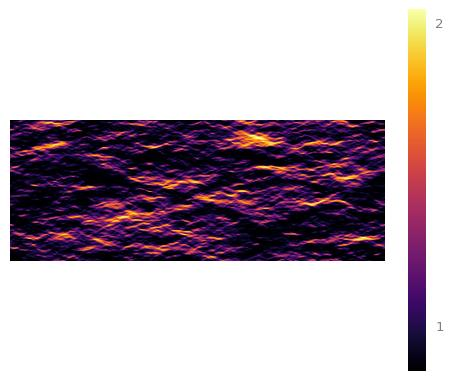

In [24]:
simshow(dens[:32, :, :].mean(axis=0), norm='CosmicWebNorm');

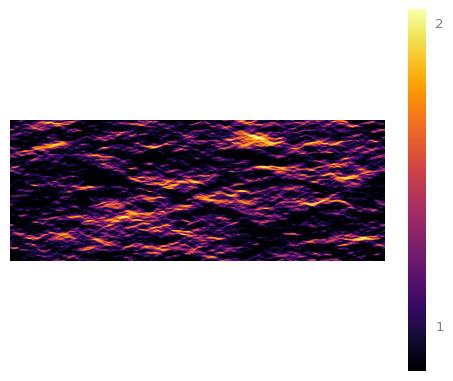

In [23]:
simshow(dens[:32, :, :].mean(axis=0), norm='CosmicWebNorm');

In [25]:
def get_sigma8(omegam, S8):
    return S8 / (jnp.sqrt(omegam / 0.3))

In [26]:
Cosmology, cosmology

(pmwd.cosmology.Cosmology,
 <module 'lemur.cosmology' from '/home/makinen/repositories/lemur/src/lemur/cosmology.py'>)

In [27]:
@partial(jax.jit, static_argnums=(2,))
def simulator(seed, θ,
             simulator_args=simulator_args
             ):
    
    #omegam,sigma8 = θ
    omegam, S8 = θ
    
    sigma8 = get_sigma8(omegam, S8) # convert from S8 coords
    
    conf = simulator_args["conf"]
    cosmo_pmwd = Cosmology.from_sigma8(
        conf, sigma8=sigma8, Omega_m=omegam, Omega_b=0.049, h=0.7, n_s=0.96)
    
    cosmo = cosmology.CosmologicalParameters(sigma8=sigma8, Omega_m=omegam)

    Nmesh = simulator_args["Nmesh"]
    Lbox = simulator_args["Lbox"]
    zmeans = simulator_args["zmeans"]
    zstds = simulator_args["zstds"]

    # try creating the box internally
    box = alpaga.simgrid.Box(Lbox, Nmesh, coord_obs)
    Nx,Ny,Nz = box.Nmesh
    
    # Generate a white noise field
    #wn = alpaga.simulate.generate_white_noise(box, seed)

    # density field
    delta_los = density_model(seed, cosmo_pmwd, conf)
    delta_los -= delta_los.mean()

    
    #los_indices = np.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))
    los_indices = simulator_args["los_indices"]

    #@partial(jax.jit, static_argnames=["delta"])
    @jax.jit
    def all_los(single_index, delta=delta_los):
        """
        helper function to map los_indices to slice through
        the delta box (will integrate in codebase soon)
        """
    
        def index_me(ind, delta=delta): # vmap over Nz
            return delta[tuple(ind)]    
    
        return jax.vmap(index_me, in_axes=(0,))(single_index)
        
    delta_los = jax.vmap(all_los)(los_indices).reshape(Nx,Ny,Nz)

    # now do convergence nonsense

    # the corresponding scale factor grid changes with cosmology
    # simulation box physical terms (comoving grid)
    chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]
    a_grid = background.compute_scale_factor_at_comoving_distance(chi_grid, cosmo)
    z_grid = a_to_z(a_grid)
    
    lensing_factor = 1.5 * cosmo.Omega_m * (cosmo.h * 100.)**2 / constants.c**2
    chi_source = chi_grid[-1]
    kernel = utils.calculate_lensing_efficiency(chi_grid, chi_source) / a_grid
    
    # kernel becomes r / costheta; integrate only up to spherical cap rmax
    delta_los *= simulator_args["spherical_cap"]
    delta_los *= simulator_args["costheta_1"]

    # Convergence field in tomographic bins

    # redshift bin weights vmap
    dr = box.Lbox[-1] / box.Nmesh[-1]

    #@partial(jax.jit, static_argnames=["delta_los"])
    @jax.jit
    def get_tomobin(zmean, zstd, delta_los=delta_los):
        
        ws = get_weights_in_chi(z_grid, 
                                a_grid,
                                chi_grid,
                                zmean, 
                                std=zstd
                               ) 
        
        def fn(k_ij): #=ws):
            """
            k_ij: 3D field slice k[i,j,:]
            weights: (Nz,) weight array
            """
            return jnp.sum(k_ij * ws * kernel * Jacobian(z_grid, cosmo) * dr) 
        
        kappa_tomo = jax.vmap(jax.vmap(fn, in_axes=(0,)), in_axes=(1,))(delta_los)
        kappa_tomo -= jnp.mean(kappa_tomo)

        return kappa_tomo * lensing_factor

    

    return jnp.squeeze(jax.vmap(get_tomobin)(zmeans, zstds))

In [28]:
# get good coordinates for S8
get_sigma8(0.3, 0.8)

Array(0.8, dtype=float64, weak_type=True)

In [29]:
θ_fid = jnp.array([0.3, 0.8])

θ_target = jnp.array([0.3, 0.811])

In [30]:
%time jax.block_until_ready(simulator(20, θ_target))
%time kappatest = jax.block_until_ready(simulator(20, θ_target))

2024-06-06 14:55:45.095793: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.15446 = s64[36864,512,1]{2,1,0} slice(s64[36864,512,3]{2,1,0} %constant.69), slice={[0:36864], [0:512], [0:1]}, metadata={op_name="jit(simulator)/jit(main)/vmap(jit(all_los))/slice[start_indices=(0, 0, 0) limit_indices=(36864, 512, 1) strides=(1, 1, 1)]" source_file="/tmp/ipykernel_628447/3202255381.py" source_line=46}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-06 14:56:33.038492: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 48.942911629s
Constant folding an 

CPU times: user 9min 17s, sys: 3min 4s, total: 12min 22s
Wall time: 4min 49s
CPU times: user 1.77 s, sys: 574 ms, total: 2.34 s
Wall time: 2.34 s


In [31]:
%time kappatest = jax.block_until_ready(simulator(20, θ_target))

CPU times: user 1.81 s, sys: 528 ms, total: 2.34 s
Wall time: 2.34 s


In [32]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=(1.3020833333333333, 1.3020833333333333, 7.8125),
              ptcl_grid_shape=(192, 192, 512),
              mesh_shape=(192, 192, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.00984375,
              symp_splits=((0, 0.5), (1, 0.5)),
     

In [30]:
kappa_extr = kappatest[1, ...].max()
kappa_extr

Array(0.094, dtype=float64)

In [31]:
kappatest.min()

Array(-0.023, dtype=float64)

/tmp/ipykernel_44481/3301866353.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


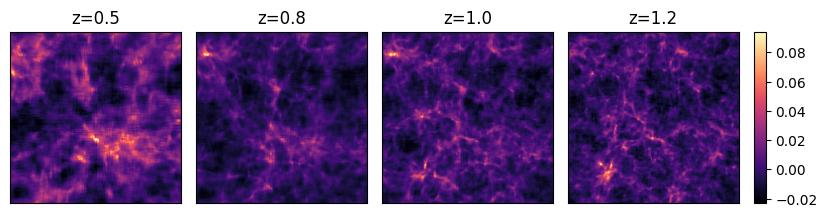

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

for i,z in enumerate(z_means_analysis):
    ax = grid[i]
    im = ax.imshow(kappatest[i], 
                   # vmin=-kappa_extr, 
                   # vmax=kappa_extr, 
                   interpolation='spline36',
                   cmap='magma'
                  )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("z=%.1f"%(z))
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

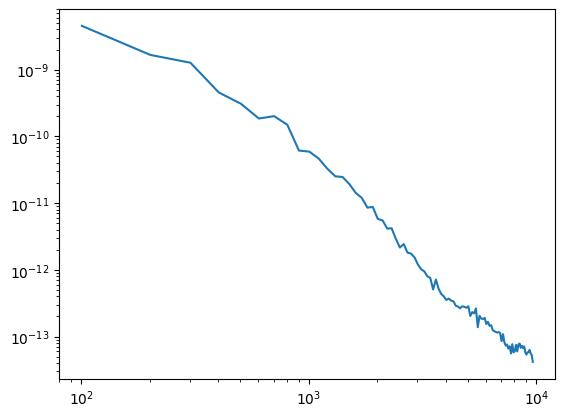

In [36]:
ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(kappatest[0], kappatest[0], chi_grid[-1], Lbox[0])
plt.loglog(ell, clsfoo)

In [37]:
outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"

jnp.savez(outdir + "test_L_%d_N_%d_Nz_512"%(L, N),
          kappa=kappatest,
          theta=θ_target
     )

In [38]:
outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"

jnp.savez(outdir + "target_L_%d_N_%d_Nz_512"%(L, N),
          kappa=kappatest,
          theta=θ_target
     )

## set up moped for the problem

In [39]:
### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
θ_fid = jnp.array([0.3, 0.8])
δθ = 2*jnp.array([0.0115, 0.01])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 3000
n_d = 750

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.288 0.8  ]
 [0.3   0.79 ]
 [0.311 0.8  ]
 [0.3   0.81 ]]


In [40]:
θ_der.shape

(4, 2)

In [41]:
import jax.random as jrnd

key1 = jrnd.PRNGKey(44)
key2 = jrnd.PRNGKey(45)

fid_keys = jnp.arange(n_s)
derv_keys = jnp.arange(n_d) + 3000



#derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0)

In [42]:
jnp.repeat(derv_keys, θ_der.shape[0], axis=0)[:10]

Array([3000, 3000, 3000, 3000, 3001, 3001, 3001, 3001, 3002, 3002], dtype=int64)

In [43]:
jnp.tile(θ_der, (n_d, 1))[:10]

Array([[0.288, 0.8  ],
       [0.3  , 0.79 ],
       [0.311, 0.8  ],
       [0.3  , 0.81 ],
       [0.288, 0.8  ],
       [0.3  , 0.79 ],
       [0.311, 0.8  ],
       [0.3  , 0.81 ],
       [0.288, 0.8  ],
       [0.3  , 0.79 ]], dtype=float64)

In [44]:
n_d * 4

3000

In [46]:
# now make a bunch of simulations (batch in size 50)
batch = 1
input_shape = (4,N,N)
outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"

# first do derivative
#derv = []
all_derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0)
all_derv_theta = jnp.tile(θ_der, (n_d, 1))

for i in tqdm(range(n_d*4)):

    numderv = simulator(all_derv_keys[i], all_derv_theta[i])
    jnp.save(outdir + "derv/" + "sim_%d"%(i), numderv)


100%|██████████| 3000/3000 [1:57:22<00:00,  2.35s/it]


In [ ]:
derv.shape

In [ ]:
plt.imshow(derv[0, 0, 0, 3, ...])
plt.colorbar()

In [43]:
derv.shape

(750, 2, 2, 4, 128, 128)

In [56]:
lpt_order

2

In [44]:
L

500

In [27]:
outdir

'/data101/makinen/lemur_sims/pm_sims/'

In [47]:
# now make a bunch of simulations (batch in size 50)
batch = 1
input_shape = (4,N,N)
outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"

# now fiducial
   
for i in tqdm(range(n_s)):
    
    #sims = jax.vmap(simulator)(fid_keys[i*batch:(i+1)*batch], jnp.ones((batch, θ_fid.shape[0]))*θ_fid)
    #sims = jax.vmap(mysim)(fid_keys[i*batch:(i+1)*batch])
    #fid.append(sims)

    #fid = fid.at[i*batch:(i+1)*batch].set(
    #                simulator(fid_keys[i], θ_fid)
    #)
    sim = simulator(fid_keys[i], θ_fid)

    jnp.save(outdir + "fid/" + "sim_%d"%(i), sim)

100%|██████████| 3000/3000 [1:57:19<00:00,  2.35s/it]


In [48]:
import gc
gc.collect()

474

In [ ]:
outdir = "/data101/makinen/lemur_sims/pm_sims/"
jnp.save(outdir + "fid_S8_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d"%(L, N, θ_fid[0]*10, θ_fid[1]*10), fid)

In [ ]:
# now make a bunch of simulations (batch in size 50)
batch = 2
input_shape = (4,N,N)

# now fiducial
fid = jnp.zeros((n_s,) + (input_shape))

# would this compile faster if I just broadcasted the vmap over copies of θ_fid 
mysim = lambda s: simulator(s, θ=θ_fid)
                            
for i in tqdm(range(n_s)):
    
    #sims = jax.vmap(simulator)(fid_keys[i*batch:(i+1)*batch], jnp.ones((batch, θ_fid.shape[0]))*θ_fid)
    #sims = jax.vmap(mysim)(fid_keys[i*batch:(i+1)*batch])
    #fid.append(sims)

    fid = fid.at[i].set(
                    simulator(fid_keys[i], θ_fid)
    )

    

#fid = jnp.conca

In [52]:
fid.shape, L

((3000, 4, 128, 128), 500)

In [ ]:
outdir = "/data101/makinen/lemur_sims/pm_sims/"
jnp.save(outdir + "fid_S8_L_%d_N_%d_Nz_512_pm_Om_%d_s8_%d"%(L, N, θ_fid[0]*10, θ_fid[1]*10), fid)

In [33]:
derv = jnp.load(outdir + "derv_new_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10))

In [57]:
fid.shape, derv.shape

((3000, 4, 128, 128), (750, 2, 2, 4, 128, 128))

In [30]:
lpt_order

0

# generate a shitton of simulations over a prior

In [33]:
import jax.random as jrnd

def get_S8(omegam, sigma8):
    return sigma8 * (jnp.sqrt(omegam / 0.3))

key1 = jrnd.PRNGKey(44)
key2 = jrnd.PRNGKey(45)


num_sims = 5000
key,rng = jrnd.split(key1)

# DIFFERENT RANDOM SEEDS !
# omegams = jrnd.uniform(key1, shape=(num_sims,), minval=0.15, maxval=0.7)
# S8s = jrnd.uniform(key2, shape=(num_sims,), minval=0.35, maxval=1.52)

# smaller prior !
omegams = jrnd.uniform(key1, shape=(num_sims,), minval=0.15, maxval=0.5)
S8s = jrnd.uniform(key2, shape=(num_sims,), minval=0.35, maxval=1.0)

θ_prior = jnp.stack([omegams, S8s], -1)

prior_keys = jnp.arange(num_sims) + 345666

outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"
# save the prior parameter draws
jnp.save(outdir + "smaller_prior_theta", θ_prior)

# now make a bunch of simulations

for i in tqdm(range(num_sims)):

    sim = simulator(prior_keys[i], θ_prior[i])
    jnp.save(outdir + "smaller_prior/" + "sim_%d"%(i), sim)


  0%|          | 0/5000 [00:00<?, ?it/s]2024-06-06 15:04:08.981160: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  %slice.15446 = s64[36864,512,1]{2,1,0} slice(s64[36864,512,3]{2,1,0} %constant.69), slice={[0:36864], [0:512], [0:1]}, metadata={op_name="jit(simulator)/jit(main)/vmap(jit(all_los))/slice[start_indices=(0, 0, 0) limit_indices=(36864, 512, 1) strides=(1, 1, 1)]" source_file="/tmp/ipykernel_628447/3202255381.py" source_line=46}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-06 15:04:51.657264: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation

In [45]:
L

250

In [49]:
outdir = "/data101/makinen/lemur_sims/pm_sims/"

jnp.savez(outdir + "prior_S8_L_%d_N_%d_Nz_512"%(L, N),
          prior_sims=prior_sims,
          prior_theta=θ_prior
         )

In [50]:
prior_sims.shape

(5000, 4, 64, 64)

In [16]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"
jnp.save(outdir + "prior_tomo_L_%d_N_%d_Nz_512_LPT%d"%(L, N, lpt_order), prior_sims)

In [64]:
%time kappatest = jax.block_until_ready(simulator(20, jnp.array([0.3, 0.8])))

CPU times: user 138 ms, sys: 65.1 ms, total: 203 ms
Wall time: 667 ms


/tmp/ipykernel_44481/3301866353.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


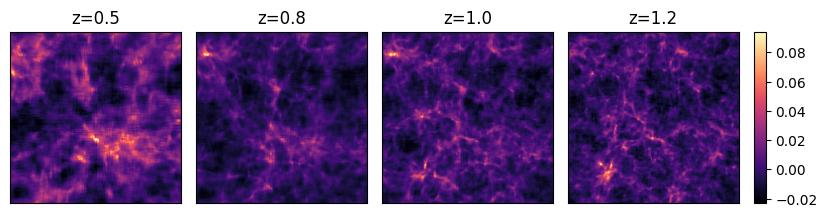

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

for i,z in enumerate(z_means_analysis):
    ax = grid[i]
    im = ax.imshow(kappatest[i], 
                   # vmin=-kappa_extr, 
                   # vmax=kappa_extr, 
                   interpolation='spline36',
                   cmap='magma'
                  )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("z=%.1f"%(z))
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()